In [23]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
plt.style.use('default')           # 默认风格
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

In [24]:
df_invest = pd.read_excel(r'作業一數據.xlsx', sheet_name='資產配置數據集合', index_col=0)
df_invest = df_invest.iloc[:, :4]
d_start = pd.to_datetime('2013-12-01')
d_end = pd.to_datetime('2024-09-30')
df_invest = df_invest.query('index > @d_start and index <= @d_end')

In [25]:
# 相關係數
df_corr = df_invest.iloc[3:, :].pct_change().corr()

In [26]:
df_corr

,富达基金_环球科技基金_净值,纳斯达克100指数,美国国债_摊余成本法复利计算净值,3081.HK價值黃金基金_淨值
富达基金_环球科技基金_净值,1.000000,0.832460,0.016606,-0.110759
纳斯达克100指数,0.832460,1.000000,-0.002656,0.066317
美国国债_摊余成本法复利计算净值,0.016606,-0.002656,1.000000,0.000735
3081.HK價值黃金基金_淨值,-0.110759,0.066317,0.000735,1.000000


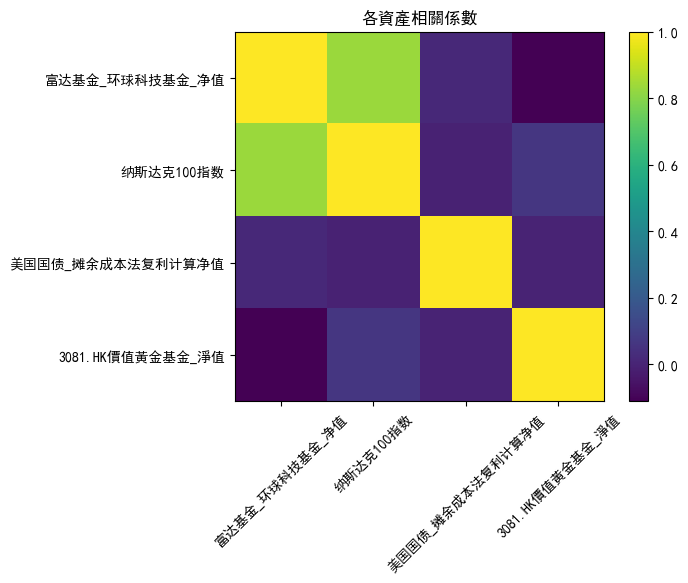

In [27]:
plt.figure()
plt.imshow(df_corr)
plt.xticks([0,1,2,3], df_corr.columns.tolist(), rotation=45)
plt.yticks([0,1,2,3], df_corr.index.tolist())
plt.title('各資產相關係數')
plt.colorbar()
plt.show()

In [28]:
# 进行正態檢驗  數據量太少了, 正態檢驗就算了
import scipy.stats as scs
def normality_test(array):
    print('Norm test p-value %14.3f' % scs.normaltest(array)[1])
for c in df_invest.columns:
    print('\nResults for {}'.format(c))
    print('-'*32)
    log_data = np.array(df_invest[c].pct_change().dropna())
    normality_test(log_data)
    del log_data


Results for 富达基金_环球科技基金_净值
--------------------------------
Norm test p-value          0.489

Results for 纳斯达克100指数
--------------------------------
Norm test p-value          0.475

Results for 美国国债_摊余成本法复利计算净值
--------------------------------
Norm test p-value          0.059

Results for 3081.HK價值黃金基金_淨值
--------------------------------
Norm test p-value          0.331


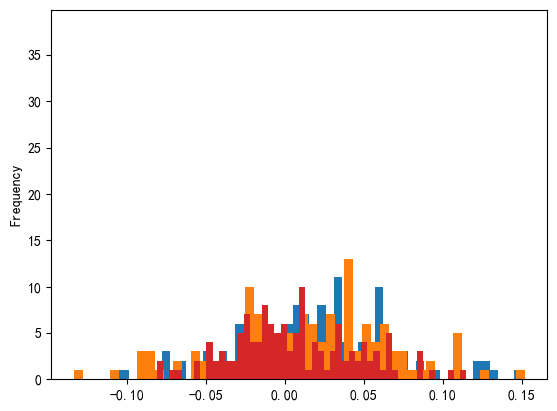

In [29]:
for c in df_invest.columns:
    df_invest[c].pct_change().plot(kind='hist', bins=50)

In [30]:
# 計算組合年化波動率
def get_std(weight, cov_pctchange):
    xx = np.dot(weight, cov_pctchange)
    xx = np.dot(weight, xx)
    return np.sqrt(xx) * np.sqrt(12)

In [31]:
# 計算組合預期收益率
s_return = (df_invest.iloc[-1, :] / df_invest.iloc[0, :]) ** (12 / (df_invest.shape[0]-1)) - 1
s_return = s_return.values
def get_return(weight, s_return):
    return np.sum(weight * s_return)

In [49]:
df_weights = np.random.random((1000000, 4))
df_weights = df_weights.T / df_weights.sum(axis=1)
df_weights = df_weights.T
df_weights = pd.DataFrame(df_weights)
df_weights.columns = df_invest.columns

In [57]:
df_weights

,富达基金_环球科技基金_净值,纳斯达克100指数,美国国债_摊余成本法复利计算净值,3081.HK價值黃金基金_淨值
0,0.333918,0.321734,0.313940,0.030408
1,0.106650,0.059717,0.427352,0.406282
2,0.312978,0.154449,0.078891,0.453682
3,0.017852,0.231322,0.188945,0.561881
4,0.181267,0.180603,0.443305,0.194825
...,...,...,...,...
999995,0.011455,0.084260,0.425582,0.478703
999996,0.106091,0.340766,0.421844,0.131298
999997,0.152438,0.157340,0.454697,0.235525
999998,0.402386,0.033330,0.543441,0.020842


In [58]:
cov_pctchange = df_invest.pct_change().dropna().cov().values

df_weights['年化波動率'] = None
df_weights['預期年化收益率'] = None
for i in tqdm(range(df_weights.shape[0])):
    weight = df_weights.iloc[i, :df_invest.shape[1]].values
    df_weights.loc[df_weights.index[i], '年化波動率'] = get_std(weight, cov_pctchange)
    df_weights.loc[df_weights.index[i], '預期年化收益率'] = get_return(weight, s_return) 

100%|██████████| 1000000/1000000 [02:22<00:00, 6994.59it/s]


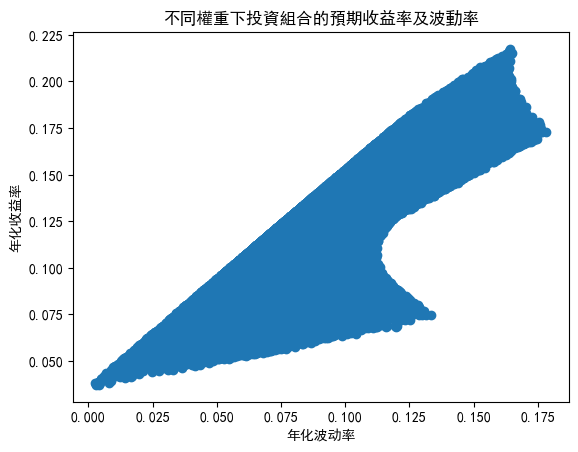

In [270]:
plt.figure()
plt.scatter(df_weights['年化波動率'], df_weights['預期年化收益率'])
plt.xlabel('年化波动率')
plt.ylabel('年化收益率')
plt.title('不同權重下投資組合的預期收益率及波動率')
plt.show()

In [107]:
# 當預期年化收益率大於10%時的年華波動率
std_min = df_weights.loc[df_weights['預期年化收益率']>=0.10]['年化波動率'].min()
s_weights = df_weights.loc[df_weights['年化波動率']==std_min].iloc[0, :]
s_weights

富达基金_环球科技基金_净值      0.321343
纳斯达克100指数           0.000058
美国国债_摊余成本法复利计算净值    0.531201
3081.HK價值黃金基金_淨值    0.147397
年化波動率               0.055057
預期年化收益率             0.100001
Name: 543719, dtype: object

In [108]:
# 投資組合淨值
s_portfolio_nav = ((df_invest * 100 / df_invest.iloc[0, :]) * df_weights.loc[df_weights['年化波動率']==std_min].values[0][:4]).sum(axis=1)

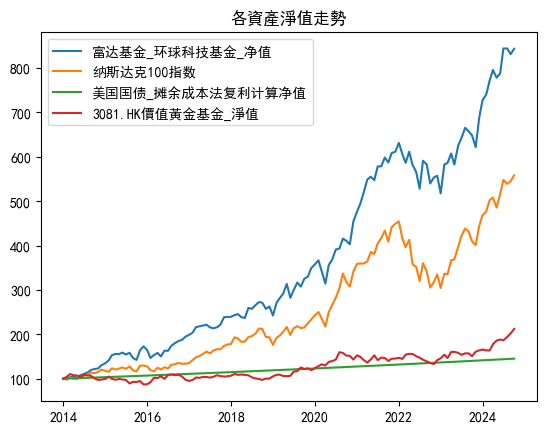

In [109]:
plt.figure()
for c in df_invest.columns:
    plt.plot(df_invest.index, df_invest[c]*100/df_invest[c][0], label=c)
# plt.plot(s_portfolio_nav.index, s_portfolio_nav, label='資產組合淨值', linewidth=3, linestyle=':')
plt.legend()
plt.title('各資產淨值走勢')
plt.show()

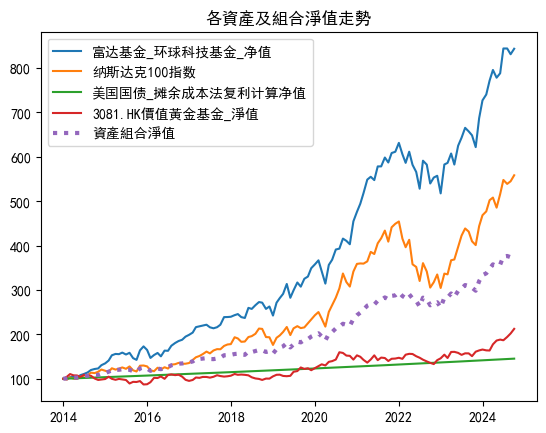

In [110]:
# 各資產走勢圖

plt.figure()
for c in df_invest.columns:
    plt.plot(df_invest.index, df_invest[c]*100/df_invest[c][0], label=c)
plt.plot(s_portfolio_nav.index, s_portfolio_nav, label='資產組合淨值', linewidth=3, linestyle=':')
plt.legend()
plt.title('各資產及組合淨值走勢')
plt.show()

In [111]:
# 回測年化波動率
_sigma = s_portfolio_nav.pct_change().std()*np.sqrt(12)
print('回測年化波動率:{:.2%}'.format(_sigma))

回測年化波動率:9.19%


In [112]:
# 回測年化收益率
_rp = (s_portfolio_nav.iloc[-1] / s_portfolio_nav.iloc[0]) ** (12 / (len(s_portfolio_nav) - 1)) - 1
print('回測年化收益率:{:.2%}'.format(_rp))

回測年化收益率:13.21%


In [113]:
# 夏普比率計算
print('無風險收益率按照3.5%計算,投資組合的夏普比率為:{:.2f}'.format((_rp - 0.035)/_sigma))

無風險收益率按照3.5%計算,投資組合的夏普比率為:1.06


# 補充_每月再平衡的組合回測

In [131]:
# 再平衡組合淨值計算
df_nav_rebalance = pd.DataFrame(index=df_invest.index, columns=['nav', 'drawdown'])
df_nav_rebalance.loc[df_nav_rebalance.index[0], 'nav'] = 100
for i in range(1, df_invest.shape[0]):
    k = (df_invest.iloc[i, :] / df_invest.iloc[i-1, :]).values * s_weights.iloc[:4].values
    df_nav_rebalance.loc[df_nav_rebalance.index[i], 'nav'] = df_nav_rebalance.loc[df_nav_rebalance.index[i-1], 'nav'] * k.sum()
# 回撤
df_nav_rebalance['drawdown'] = df_nav_rebalance['nav'] / df_nav_rebalance['nav'].cummax() - 1

In [132]:
df_nav_rebalance['drawdown']

日期
2013-12-31         0.0
2014-01-31         0.0
2014-02-28         0.0
2014-03-31         0.0
2014-04-30   -0.006853
                ...   
2024-05-31         0.0
2024-06-28         0.0
2024-07-31         0.0
2024-08-30         0.0
2024-09-30         0.0
Name: drawdown, Length: 130, dtype: object

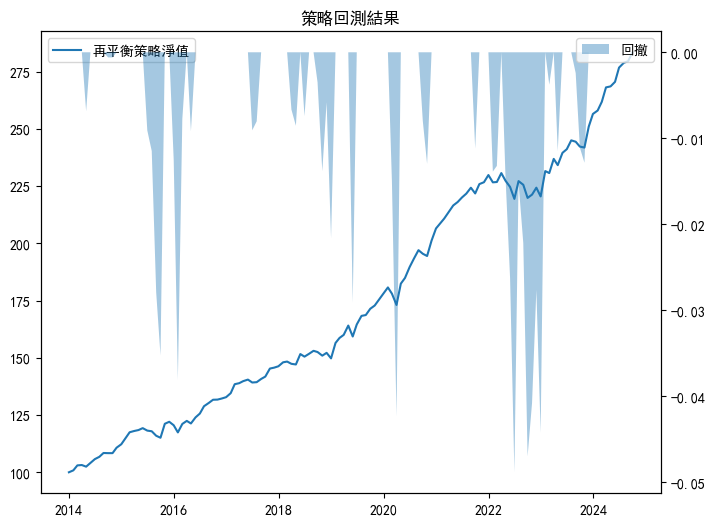

In [139]:
# 作圖
plt.figure(figsize=(8, 6))
plt.plot(df_nav_rebalance.index, df_nav_rebalance['nav'], label='再平衡策略淨值')
plt.legend(loc=2)
plt.twinx()
plt.fill(df_nav_rebalance.index, df_nav_rebalance['drawdown'], alpha=0.4, label='回撤')
plt.legend(loc=1)
plt.title('策略回測結果')
plt.show()

In [141]:
r_anu = (df_nav_rebalance['nav'].iloc[-1] / df_nav_rebalance['nav'].iloc[0]) ** (12 / (len(df_nav_rebalance)-1)) - 1
print('再平衡策略策略年化收益率{:.2%}'.format(r_anu))

再平衡策略策略年化收益率10.18%


In [147]:
_sigma_rebalance = df_nav_rebalance['nav'].pct_change().std() * np.sqrt(12)
print('無風險收益率按照3.5%計算,投資組合的夏普比率為:{:.2f}'.format((r_anu - 0.035)/_sigma_rebalance))

無風險收益率按照3.5%計算,投資組合的夏普比率為:1.21
